📩 SMS Spam Detection using TF-IDF and Multinomial Naive Bayes
This notebook demonstrates a complete spam classifier using SMS message data. We will:

- Clean and preprocess the dataset
- Vectorize the text using TF-IDF
- Train different classifiers
- Evaluate the models and selected Multinomial Naive Bayes classifier
- Save it for deployment

📚 Importing Libraries

In [2]:
#importing the lib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

📥 Loading the Dataset¶

In [3]:
import chardet
with open("spam.csv", 'rb') as f:
    result = chardet.detect(f.read())
df = pd.read_csv("spam.csv", encoding=result['encoding'])


In [4]:
#overviewing the dataset 
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
578,spam,"our mobile number has won å£5000, to claim cal...",NaN,NaN,NaN
2944,ham,"Hey babe, sorry i didn't get sooner. Gary can ...",NaN,NaN,NaN
2584,ham,Hi happy birthday. Hi hi hi hi hi hi hi,NaN,NaN,NaN
1505,ham,Total video converter free download type this ...,NaN,NaN,NaN
4662,ham,No. Yes please. Been swimming?,NaN,NaN,NaN


Data Cleaning 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


From above , we can clearly see in columns 2,3 and 4 most of the values are null . So , dropping them is the best.

In [6]:
#dropping last three columns 
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
#renaming the columns , since there are not informative 
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
5402,ham,Hi babe its me thanks for coming even though i...
257,ham,Where are you lover ? I need you ...
4575,spam,Congratulations ur awarded 500 of CD vouchers ...
5231,ham,I realise you are a busy guy and i'm trying no...
1005,ham,Give me a sec to think think about it


In [9]:
#label encoding 
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df.target=encoder.fit_transform(df['target'])
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
#missing values 
df.isnull().sum()

target    0
text      0
dtype: int64

In [11]:
#duplicate values 
df.duplicated().sum()

np.int64(403)

In [12]:
df.shape


(5572, 2)

In [13]:
df.drop_duplicates(keep='first',inplace=True)
df.shape

(5169, 2)

EDA

In [14]:
#checking data distribution of spam or ham 
df.target.value_counts()

target
0    4516
1     653
Name: count, dtype: int64

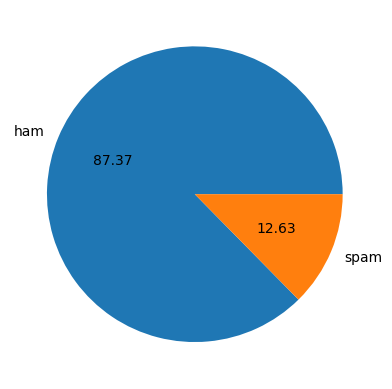

In [15]:
plt.pie(df.target.value_counts(),labels=['ham','spam'],autopct="%.2f")
plt.show()

from above , it can be seen that the data is imbalance 

In [16]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [17]:
#numver of characters in text
df['num_character']=df.text.apply(len)
df.head()

,target,text,num_character
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [18]:
#numbers of words
df['num_words']=df.text.apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,target,text,num_character,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [19]:
#numbers of sentences
df['num_sent']=df.text.apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,target,text,num_character,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [20]:
df.describe()

,target,num_character,num_words,num_sent
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [21]:
#ham
df[df.target==0][['num_character','num_words','num_sent']].describe()

,num_character,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
#spam
df[df.target==1][['num_character','num_words','num_sent']].describe()


,num_character,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [23]:
import seaborn as sns

<Axes: xlabel='num_character', ylabel='Count'>

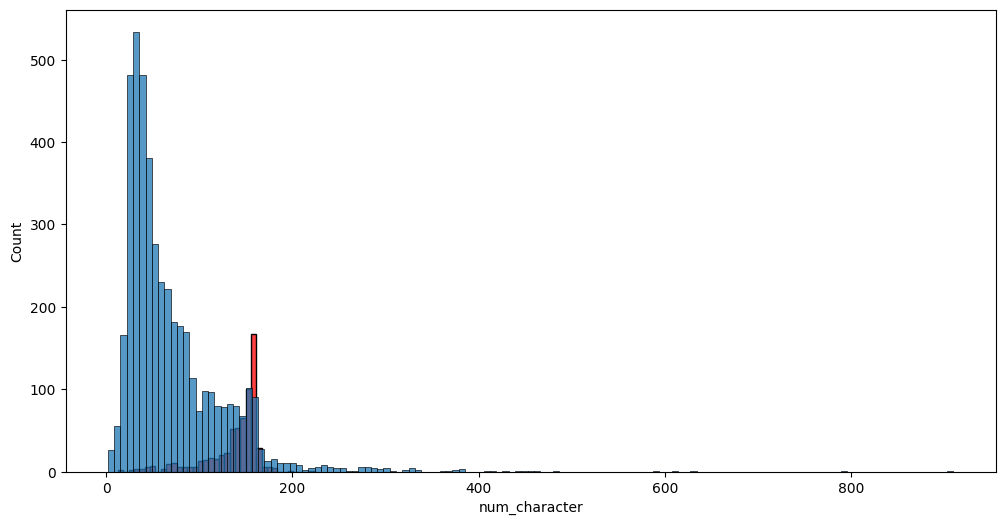

In [24]:
plt.figure(figsize=(12,6))
sns.histplot(df[df.target==1]['num_character'],color='red')
sns.histplot(df[df.target==0]['num_character'])


<Axes: xlabel='num_words', ylabel='Count'>

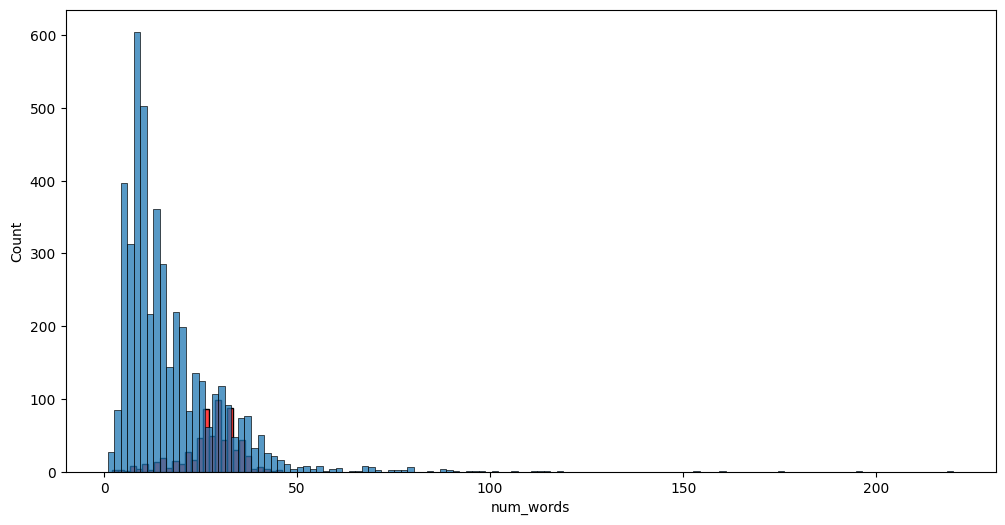

In [25]:
plt.figure(figsize=(12,6))
sns.histplot(df[df.target==1]['num_words'],color='red')
sns.histplot(df[df.target==0]['num_words'])

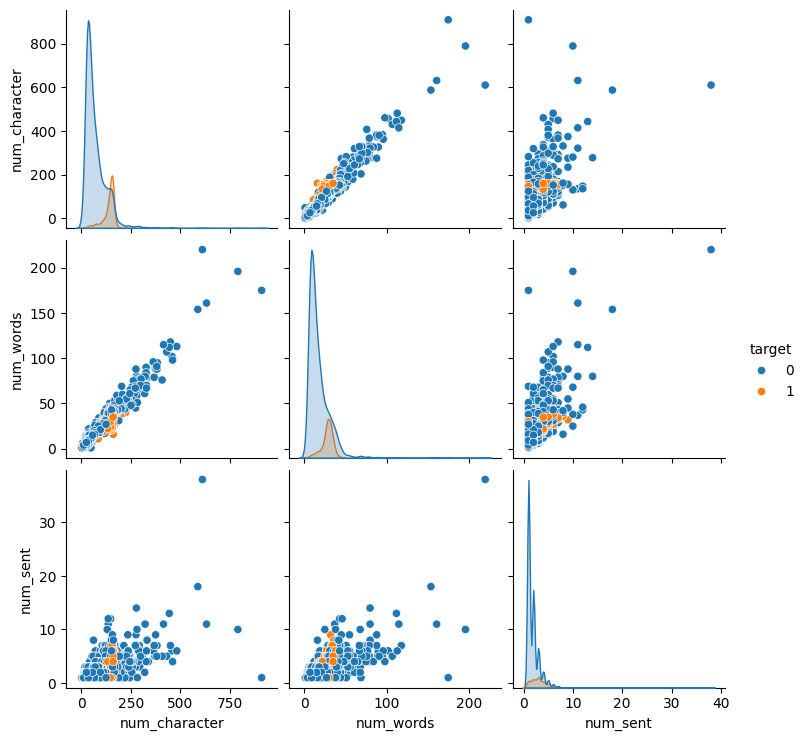

In [26]:
sns.pairplot(df,hue='target')

<Axes: >

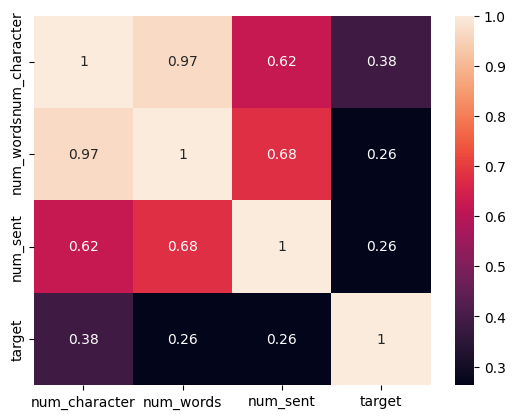

In [27]:
sns.heatmap(df[['num_character','num_words','num_sent','target']].corr(),annot=True)

from above relation , it can be seen that target is highly related to num_character and others are also related to num_characters highly .Thus , we will take num_character feature for model building for now!

Data(text) preprocessing:
1) Lowercase
2) Tokenization
3) Removing special characters
4) Removing stop words and punctuation
5) Stemming

In [30]:
from nltk.stem.porter import PorterStemmer
import re
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords


ps = PorterStemmer()

def transformed_text(text):
    # 1. Convert text to lowercase and removed the digits and links
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'\d+', '', text)
    # 2. Tokenize the text into words
    text = nltk.word_tokenize(text)
    
    # 3. Remove non-alphanumeric tokens (like emojis, punctuation, etc.)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    # 4. Remove stopwords and punctuation
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    
    # 5. Stemming
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    
    # 6. Return cleaned, stemmed, space-separated string
    return " ".join(y)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
df['transformed_text']=df.text.apply(transformed_text)
df.head()

,target,text,num_character,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [32]:
from wordcloud import WordCloud
wc=WordCloud(width=500,height=500,min_font_size=10,background_color="white" )

In [33]:
spam_wc=wc.generate(df[df.target==1]['transformed_text'].str.cat(sep=" "))

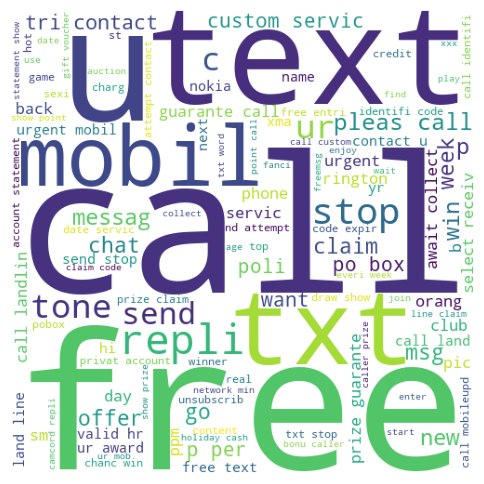

In [34]:
plt.figure(figsize=(6,14))
plt.imshow(spam_wc)
plt.axis("off")  # Hide axe
plt.show()

In [35]:
ham_wc=wc.generate(df[df.target==0]['transformed_text'].str.cat(sep=" "))

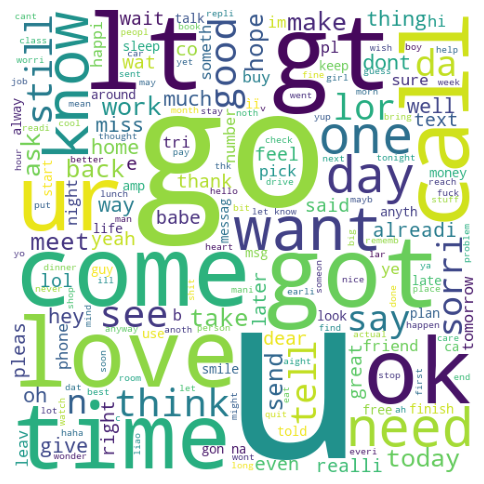

In [36]:
plt.figure(figsize=(6,14))
plt.imshow(ham_wc)
plt.axis("off")  # Hide axe
plt.show()

Model Building  and Evaluation

In [37]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv=CountVectorizer()
tfidf=TfidfVectorizer(max_features=3000)

In [38]:
X=tfidf.fit_transform(df.transformed_text).toarray()
X.shape

(5169, 3000)

In [39]:
y=df.target.values
y

array([0, 0, 1, ..., 0, 0, 0], shape=(5169,))

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=52)

In [42]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
gnb= GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()

In [43]:
gnb.fit(X_train,y_train)
y_pred1=gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8588007736943907
[[778 124]
 [ 22 110]]
0.4700854700854701


In [44]:
mnb.fit(X_train,y_train)
y_pred2=mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9709864603481625
[[902   0]
 [ 30 102]]
1.0


In [45]:
bnb.fit(X_train,y_train)
y_pred3=bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9738878143133463
[[897   5]
 [ 22 110]]
0.9565217391304348


Now checking the performance of other models in same data , to find the best one !

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



In [47]:
scv=SVC(kernel='sigmoid',gamma=1.0)
lrc=LogisticRegression(solver='liblinear',penalty='l1')
rfc=RandomForestClassifier(n_estimators=50,random_state=2)
dtc=DecisionTreeClassifier(max_depth=5)

In [48]:
mdls={
    'SVC':scv,
    'LRC':lrc,
    'RFC':rfc,
    'DTC':dtc,
    'MNB':mnb
}
     

In [49]:
def train_models(mdls,X_train,y_train,X_test,y_test):
    mdls.fit(X_train,y_train)
    y_pred=mdls.predict(X_test)
    return accuracy_score(y_test,y_pred),precision_score(y_test,y_pred)

In [50]:
accuracy = []
precision = []

for name, model in mdls.items():
    acc, prec = train_models(model, X_train, y_train, X_test, y_test)
    print("For", name)
    print("Accuracy:", acc)
    print("Precision:", prec)
    accuracy.append(acc)
    precision.append(prec)


For SVC
Accuracy: 0.9709864603481625
Precision: 0.9811320754716981
For LRC
Accuracy: 0.9622823984526112
Precision: 0.9603960396039604
For RFC
Accuracy: 0.971953578336557
Precision: 0.9904761904761905
For DTC
Accuracy: 0.9410058027079303
Precision: 0.8736842105263158
For MNB
Accuracy: 0.9709864603481625
Precision: 1.0


In [51]:
performance_df=pd.DataFrame({'Algorithms':mdls.keys(),'Accuracy':accuracy,'Precision':precision})
performance_df




,Algorithms,Accuracy,Precision
0,SVC,0.970986,0.981132
1,LRC,0.962282,0.960396
2,RFC,0.971954,0.990476
3,DTC,0.941006,0.873684
4,MNB,0.970986,1.000000


In [52]:
import pickle 
pickle.dump(tfidf,open('tfidf.pkl','wb'))
pickle.dump(mnb,open('mnb.pkl','wb'))

Till now naives bayes classifier is selected as its accuracy and presion is higher than that of other included  classsifiers , more imporvement over its accuracy may be performed in future 